Mounted at /content/drive
(284807, 31)
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std

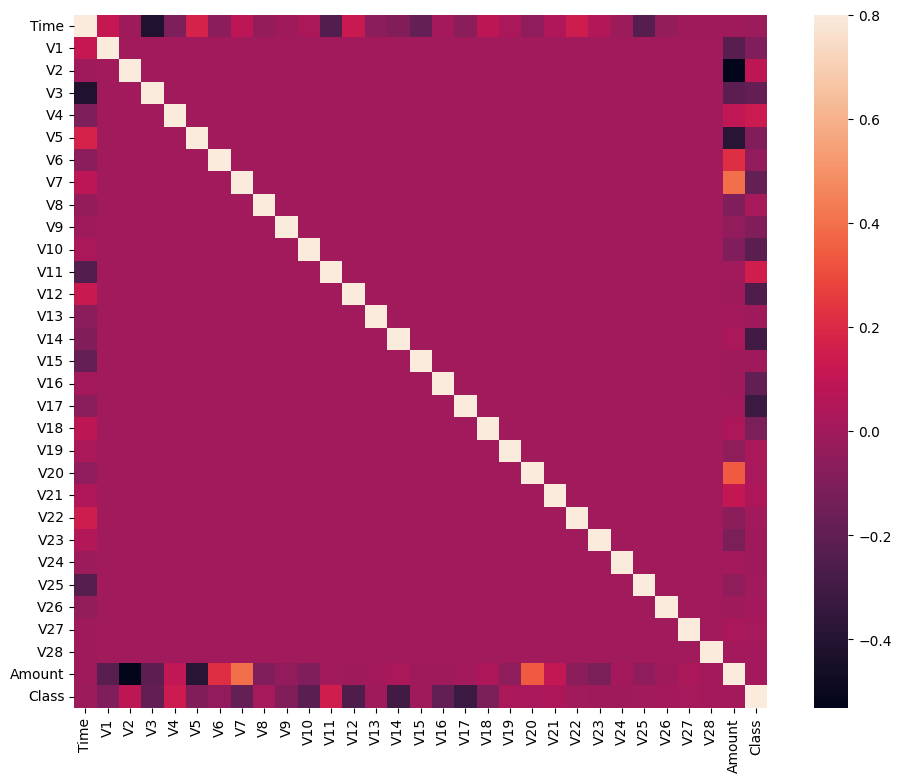

Train Epoch: 1 [0/227845 (0%)]	Loss: 0.000000
Train Epoch: 1 [6400/227845 (3%)]	Loss: 0.000000
Train Epoch: 1 [12800/227845 (6%)]	Loss: 0.000000
Train Epoch: 1 [19200/227845 (8%)]	Loss: 0.000000
Train Epoch: 1 [25600/227845 (11%)]	Loss: 0.000000
Train Epoch: 1 [32000/227845 (14%)]	Loss: 0.000000
Train Epoch: 1 [38400/227845 (17%)]	Loss: 0.000000
Train Epoch: 1 [44800/227845 (20%)]	Loss: 0.000000
Train Epoch: 1 [51200/227845 (22%)]	Loss: 0.000000
Train Epoch: 1 [57600/227845 (25%)]	Loss: 0.000000
Train Epoch: 1 [64000/227845 (28%)]	Loss: 0.000000
Train Epoch: 1 [70400/227845 (31%)]	Loss: 0.000121
Train Epoch: 1 [76800/227845 (34%)]	Loss: 11.163774
Train Epoch: 1 [83200/227845 (37%)]	Loss: 0.000004
Train Epoch: 1 [89600/227845 (39%)]	Loss: 0.000000
Train Epoch: 1 [96000/227845 (42%)]	Loss: 0.000000
Train Epoch: 1 [102400/227845 (45%)]	Loss: 0.000000
Train Epoch: 1 [108800/227845 (48%)]	Loss: 0.000000
Train Epoch: 1 [115200/227845 (51%)]	Loss: 0.000000
Train Epoch: 1 [121600/227845 (53%)]

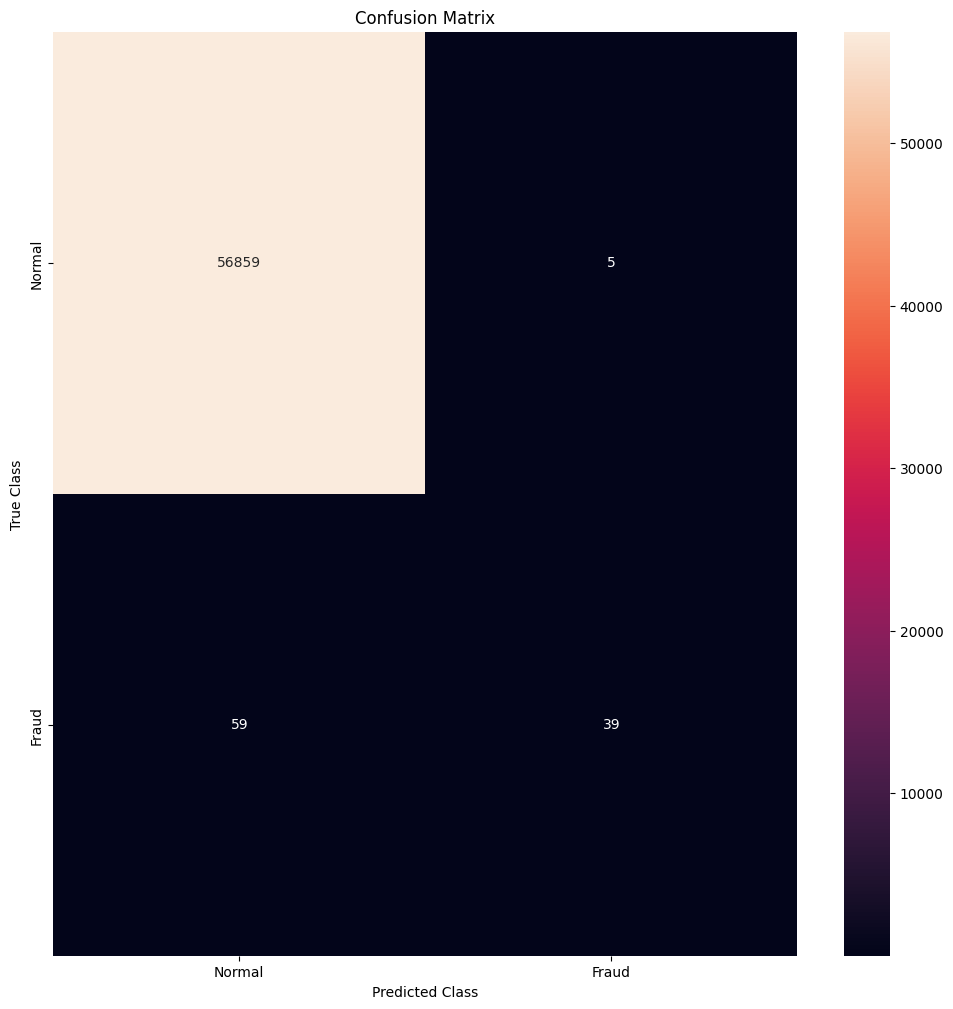

In [2]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix

# Mount Google Drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/creditcard.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Data overview
print(data.shape)
print(data.describe())

# Determine number of fraud cases in dataset
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]
outlierFraction = len(fraud) / float(len(valid))
print(outlierFraction)
print('Fraud Cases: {}'.format(len(fraud)))
print('Valid Transactions: {}'.format(len(valid)))

# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

# Dividing the features and labels
X = data.drop(['Class'], axis=1)
Y = data['Class']
xData = X.values
yData = Y.values

# Splitting into train and test sets
xTrain, xTest, yTrain, yTest = train_test_split(xData, yData, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors for differential privacy
train_dataset = TensorDataset(torch.tensor(xTrain, dtype=torch.float32), torch.tensor(yTrain, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define a PyTorch model for differential privacy training
class DummyModel(torch.nn.Module):
    def __init__(self, input_size):
        super(DummyModel, self).__init__()
        self.fc = torch.nn.Linear(input_size, 2)

    def forward(self, x):
        return self.fc(x)

# Differential privacy training function
def train_DPinput(model, device, train_loader, optimizer, epoch, mean, scale, noisetype):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        if noisetype == "Laplace":
            dist = torch.distributions.laplace.Laplace(mean, scale)
        elif noisetype == "Gaussian":
            dist = torch.distributions.normal.Normal(mean, scale)
        else:
            raise ValueError(f"Unsupported noise type: {noisetype}")
        noise_added = dist.sample(data.size()).to(device)
        data = data + noise_added
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
                f"\tLoss: {loss.item():.6f}"
            )

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model and optimizer
input_size = xTrain.shape[1]
model = DummyModel(input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Differential privacy training parameters
mean = 0
scale = 2
noisetype = "Laplace"
num_epochs = 1

# Train with differential privacy
for epoch in range(1, num_epochs + 1):
    train_DPinput(model, device, train_loader, optimizer, epoch, mean, scale, noisetype)

# Extract noisy training data for Random Forest
noisy_xTrain = xTrain + np.random.laplace(mean, scale, xTrain.shape)

# Train Random Forest on noisy data
rfc = RandomForestClassifier()
rfc.fit(noisy_xTrain, yTrain)
yPred = rfc.predict(xTest)


print("The model used is Random Forest classifier")
acc = accuracy_score(yTest, yPred)
print("The accuracy is {}".format(acc))
prec = precision_score(yTest, yPred)
print("The precision is {}".format(prec))
rec = recall_score(yTest, yPred)
print("The recall is {}".format(rec))
f1 = f1_score(yTest, yPred)
print("The F1-Score is {}".format(f1))
MCC = matthews_corrcoef(yTest, yPred)
print("The Matthews correlation coefficient is {}".format(MCC))

# Confusion Matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(yTest, yPred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()
